### Time Series Workshop 
# 5. Online Retail: Forecasting Challenge Sample Solution

Eh, this is a sample solution for the previous challenge. 

You were'nt supposed to see this. I didn't think anybody would open a notebook with the most uninteresting file name imaginable. Ah, whatever. &#x1F937;

In [5]:
%config InlineBackend.figure_format='retina'
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from feature_engine.creation import CyclicalFeatures
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer as ftrf

from timeseries.data import load_retail
from timeseries.utils import print_metrics
from timeseries import preprocessing as pp

DATA_DIR = Path("..") / Path("data")

## Load data

In [6]:
TARGET_COL = "sales"
SPLIT_DATE = "2011-09-30"
FILE_PATH = DATA_DIR / "online_retail.csv"

df_in = load_retail(FILE_PATH)
df_in.head()

,sales
month,
1992-01-01,146376
1992-02-01,147079
1992-03-01,159336
1992-04-01,163669
1992-05-01,170068


## Analyze data

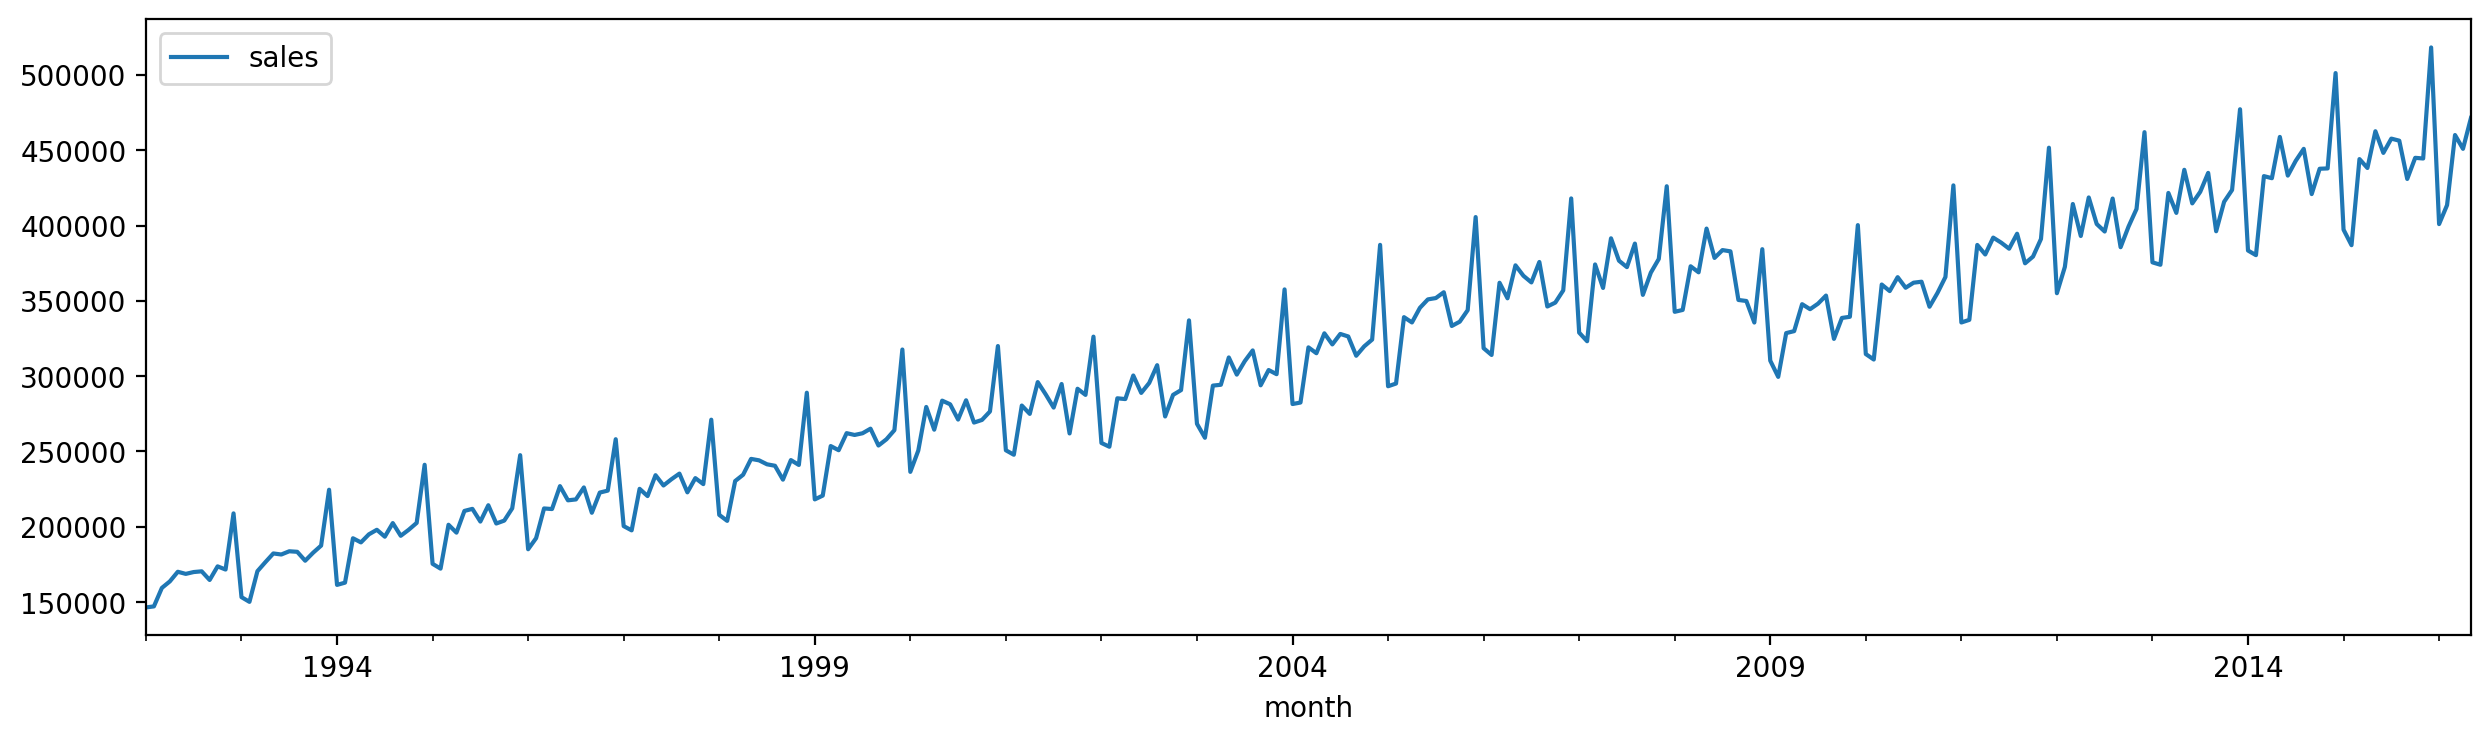

In [7]:
df = df_in.copy()

_ = df.plot(figsize=[15, 4])

- Looks pretty benign, no missing values 
- Yearly seasonality pattern clearly visible!
- Strong trend upwards!
- The econmoic crisis in 2008 is clearly visible in the data as a cusp

 # Seasonality

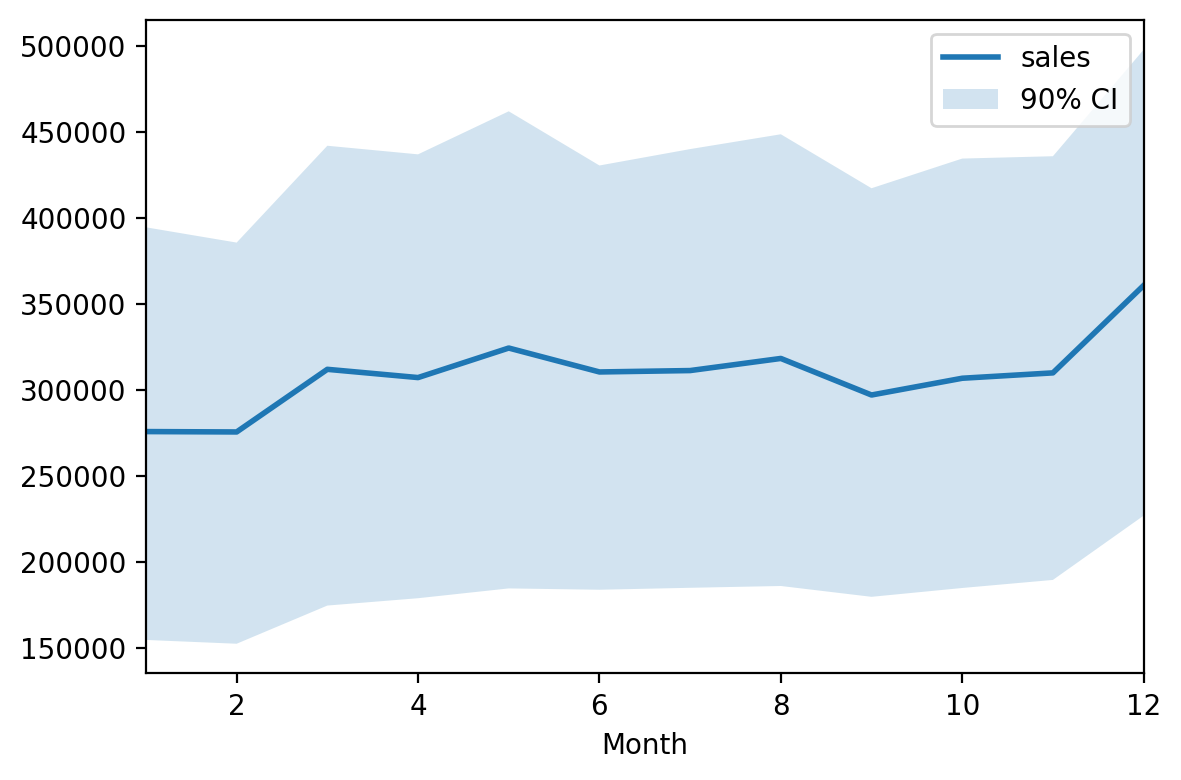

In [8]:
def q05(x):
    return x.quantile(0.05)


def q95(x):
    return x.quantile(0.95)


_, ax = plt.subplots(figsize=(6, 4))
df_season = df[[TARGET_COL]].copy()

# Group by hour of the day and compute mean and 90% confidence interval
df_season["m"] = df_season.index.month
df_time_season = df_season.groupby("m")[[TARGET_COL]].agg(["mean", q05, q95])

# Plot mean values
ax.plot(df_time_season[TARGET_COL]["mean"], label=TARGET_COL, linewidth=2)

# Plot confidence intervals
ax.fill_between(
    df_time_season.index,
    df_time_season[TARGET_COL]["q05"],
    df_time_season[TARGET_COL]["q95"],
    alpha=0.2,
    label="90% CI",
)

ax.set_xlabel("Month")
ax.set_xlim((1, 12))
ax.legend()
plt.tight_layout()

- Seasonality analysis by grouping data is not helpful here, due to the strong trend!
- We can use the `seasonal_decompose` function from `statsmodels` to decompose the time series into trend, seasonality and residuals

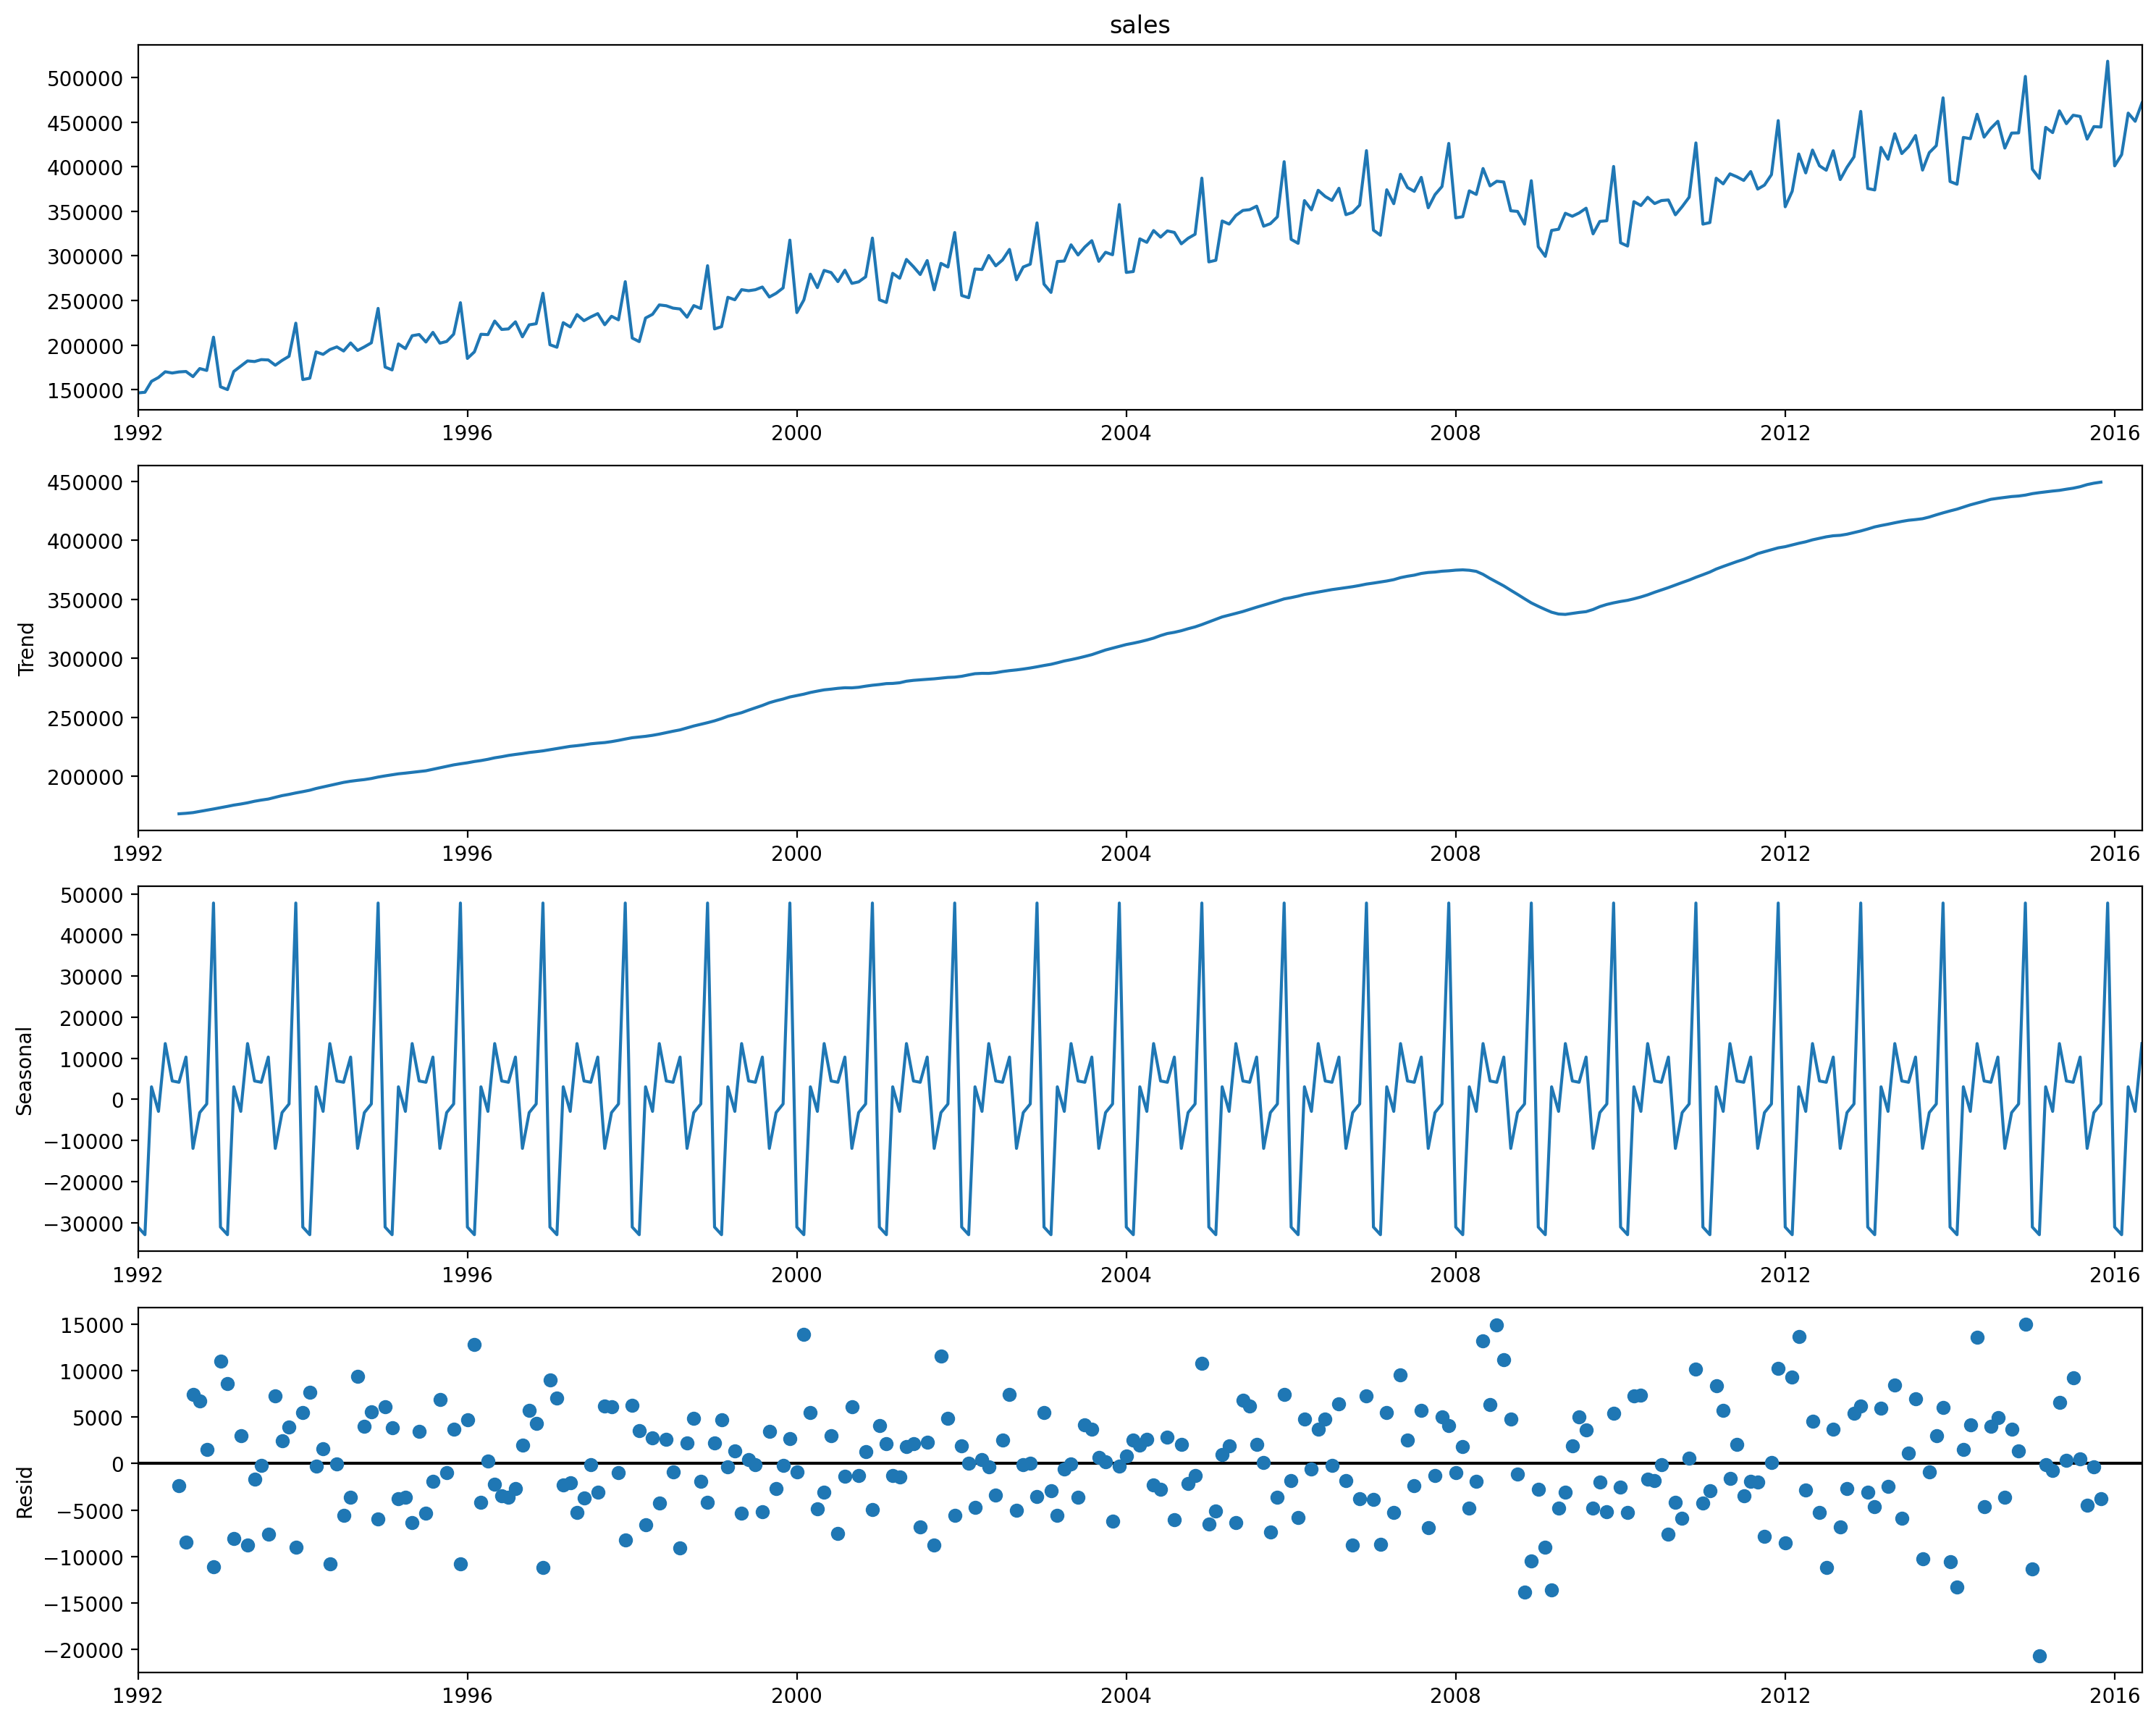

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df[TARGET_COL], model='additive')
fig = result.plot()
_ = fig.set_size_inches(15, 12)
_ = plt.tight_layout()

Looks good to me! 
- Strong trend
- Yearly seasonality
- Residuals are pretty random, but with a slight upwards trend

I'll build a simple model out of this!

## Build instructive model

### 1. Train-test split
- Before using the seasonality pattern and trend we got form the decomposition, we need to split off the test set as to not fall prey to look-ahead bias

In [10]:
df_train = df.loc[df.index < SPLIT_DATE].copy()
df_test = df.loc[df.index >= SPLIT_DATE].copy()

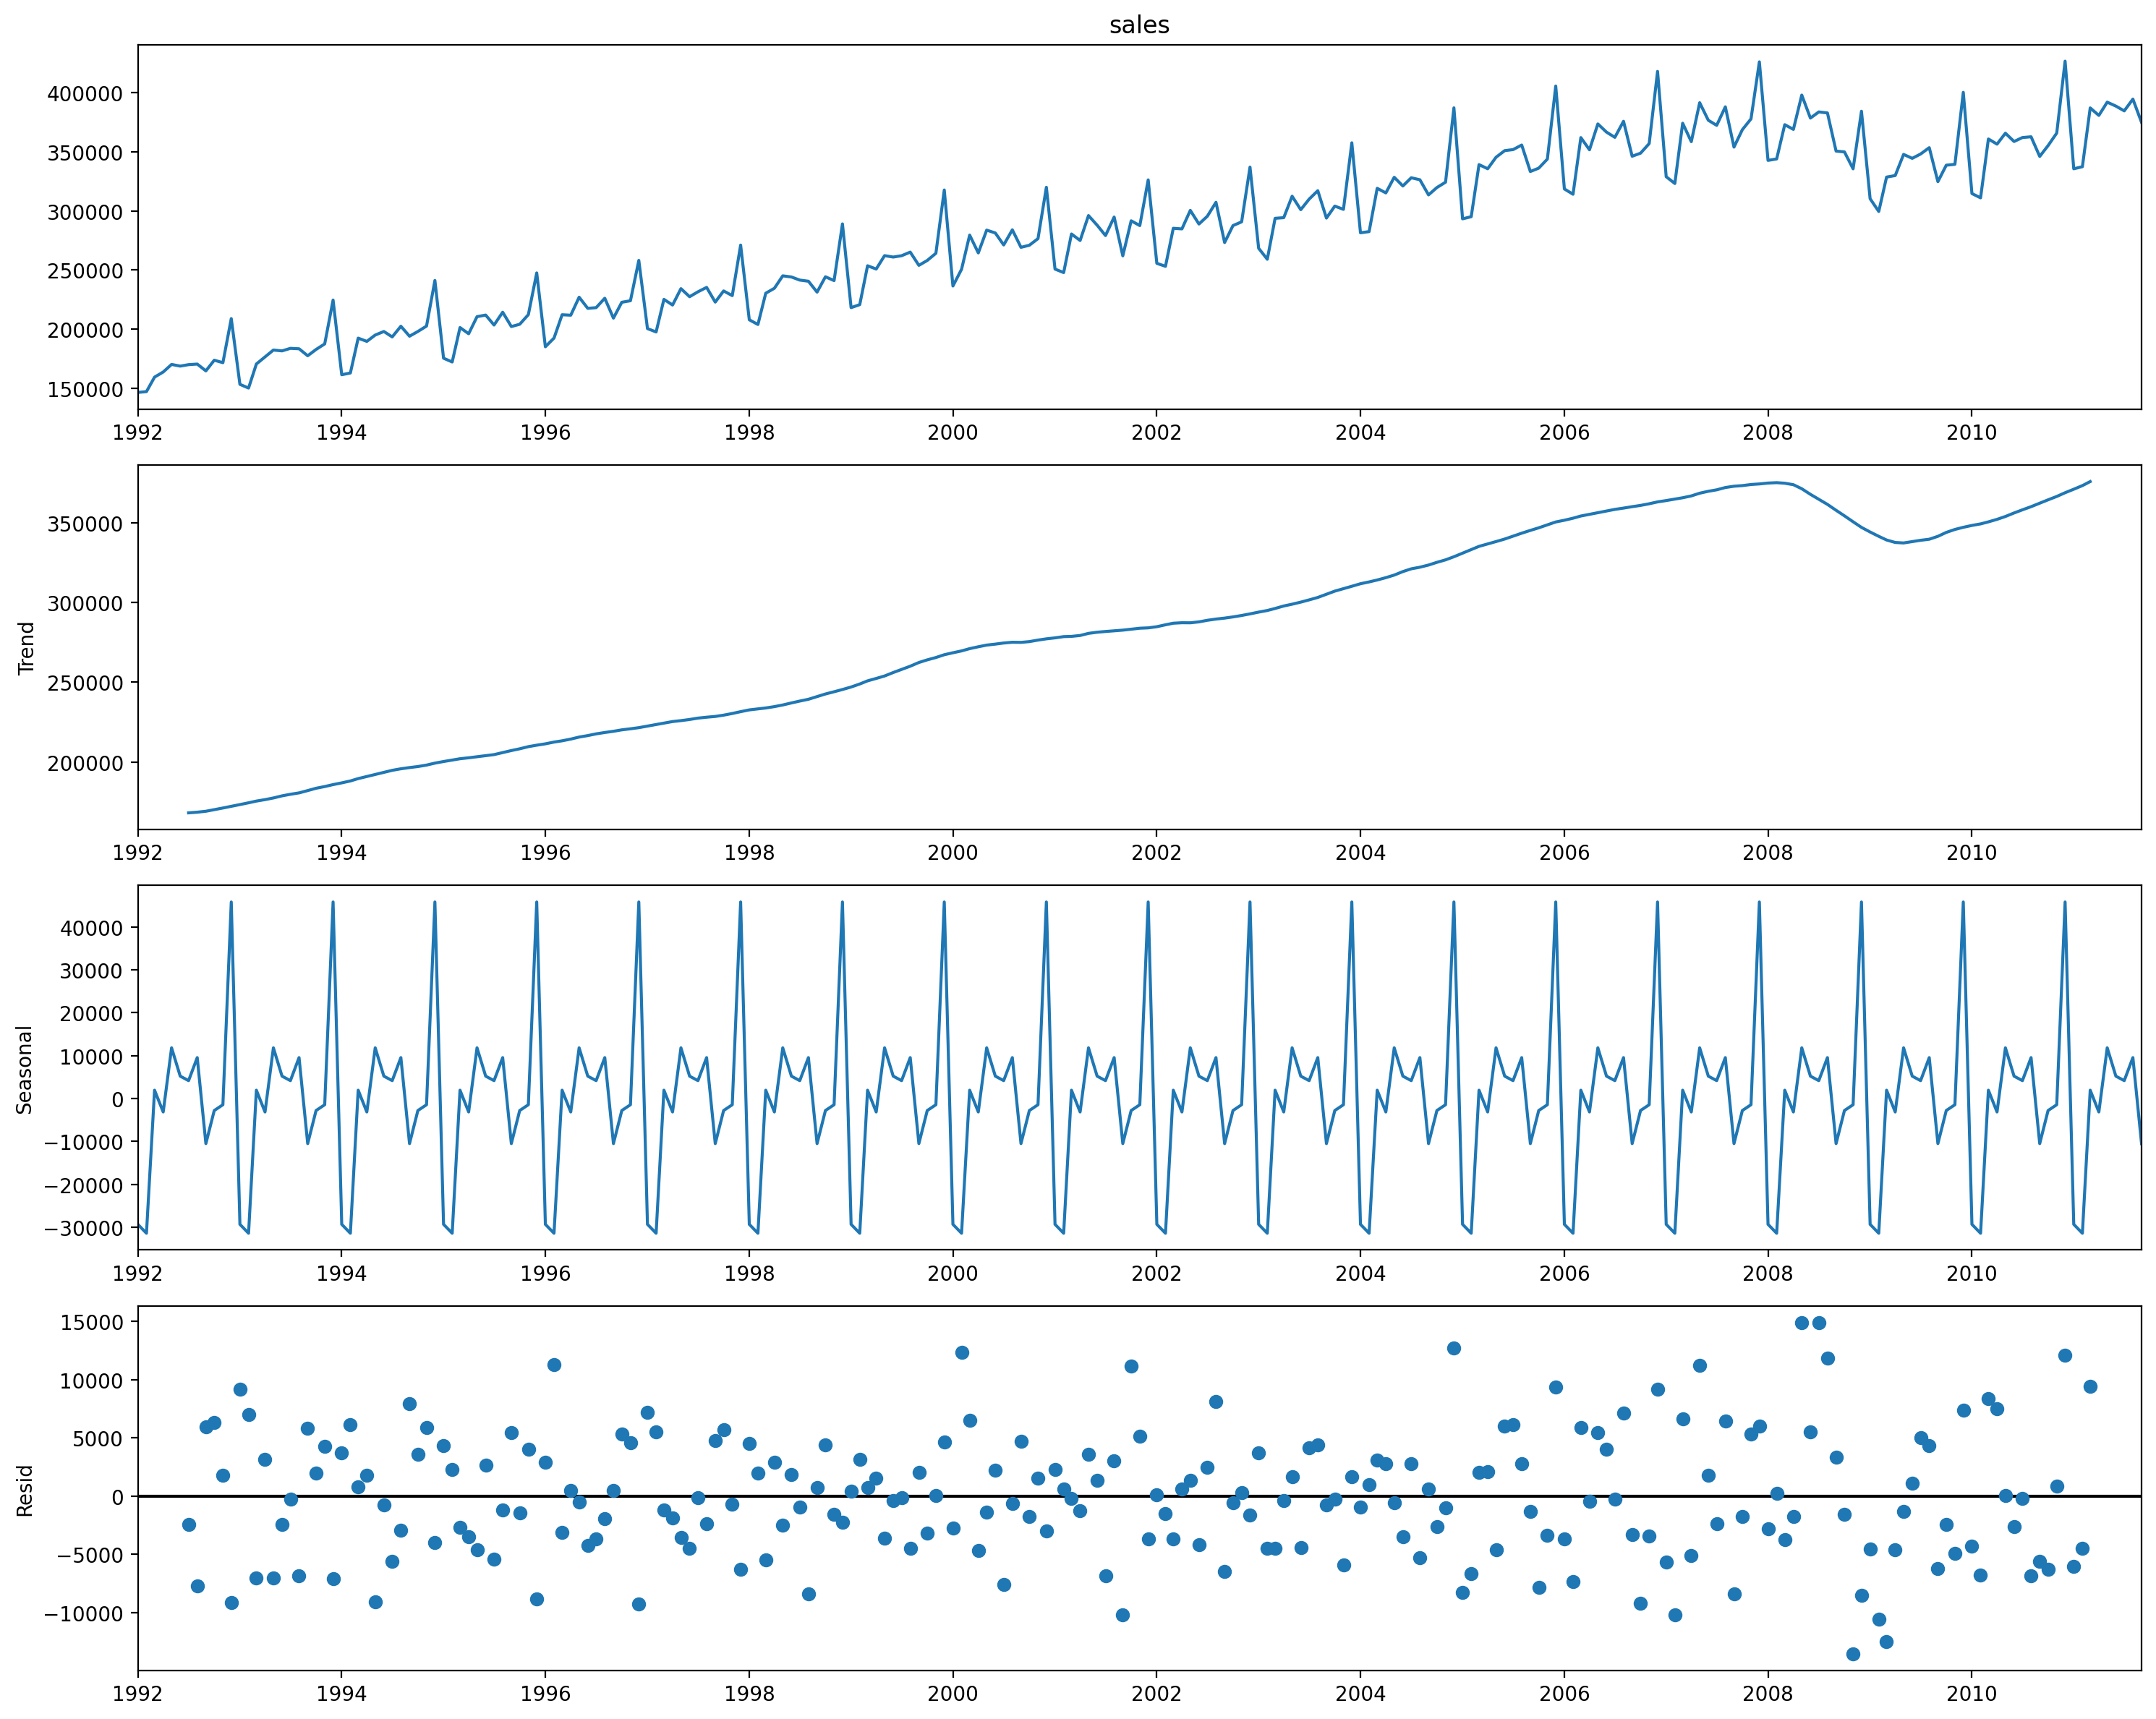

In [11]:
result = seasonal_decompose(df_train[TARGET_COL], model='additive')
fig = result.plot()
_ = fig.set_size_inches(15, 12)
_ = plt.tight_layout()

- If we now only take the slope of the trend and the seasonality pattern, we might already get a pretty good forecast
- Let's extract the seasonality first

Note: This is super manual stuff that's mainly meant to be instructive. In a real-world scenario, one would probably use a more sophisticated/easy to deal with model.

First, we'll extract the seasonality (mapped to the month)

{1: -29298.968435266397,
 2: -31378.87633000325,
 3: 1946.9877050844693,
 4: -3124.123527858994,
 5: 11821.425083252112,
 6: 5221.0963795484,
 7: 4179.031564733588,
 8: 9545.889020873947,
 9: -10490.630715968147,
 10: -2784.475014213773,
 11: -1437.3236984243067,
 12: 45799.96796824236}

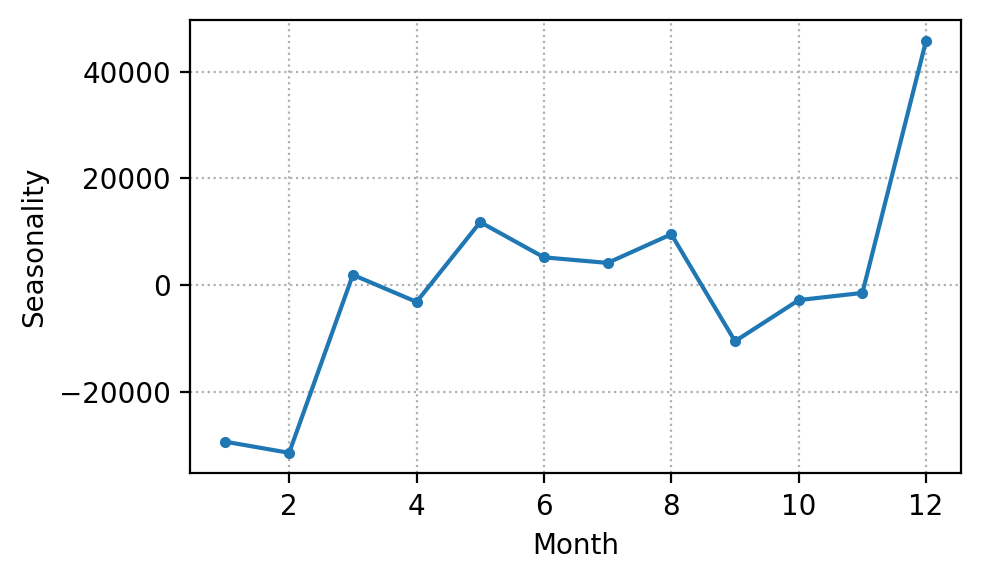

In [12]:
df_season = pd.DataFrame(result.seasonal)
seasonality = df_season.groupby(df_season.index.month)["seasonal"].mean().to_dict()

_ , ax = plt.subplots(figsize=(5, 3))
_ = ax.plot(seasonality.keys(), seasonality.values(), marker=".")
_ = ax.set_xlabel("Month")
_ = ax.set_ylabel("Seasonality")
_ = ax.grid(linestyle=":")
_ = plt.tight_layout()
seasonality

This looks ok-ish. Strong yearly seasonality. 

We'll use the dictionary for our super weird estimator!

Next, we'll create train- and test sets. Not that here, the train set just includes the extracted trend


In [15]:
trends = result.trend.dropna().copy()["2009-01-01":]
df_trainf = pd.DataFrame(index = trends.index)
df_trainf["sales"] = trends.values
df_trainf["nmonth"] = df_trainf.index.month
df_trainf["n"] = range(len(df_trainf))
df_testf = df_test.copy()
df_testf["nmonth"] = df_testf.index.month
df_testf["n"] = range(len(df_trainf), len(df_trainf) + len(df_testf))

X_trainf = df_trainf[["nmonth", "n"]]
y_trainf = df_trainf[TARGET_COL]
X_testf = df_testf[["nmonth", "n"]]
y_testf = df_testf[TARGET_COL]

df_trainf.head()

,sales,nmonth,n
month,,,
2009-01-01,344120.583333,1,0
2009-02-01,341413.958333,2,1
2009-03-01,339112.666667,3,2
2009-04-01,337566.583333,4,3
2009-05-01,337256.625000,5,4


In [16]:
df_testf.head()

,sales,nmonth,n
month,,,
2011-10-01,379364,10,27
2011-11-01,391081,11,28
2011-12-01,451669,12,29
2012-01-01,355058,1,30
2012-02-01,372523,2,31


Let's build a weird little estimator that does the final steps for us:

In [17]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import LinearRegression


class MyFunnyTrendEstimator(BaseEstimator, RegressorMixin):
    """
    Weird little estimator that fits a trend and adds some seasonality mapping in predict
    
    :param seasonality_map: dict mapping month to seasonality
    """
    def __init__(self, seasonality_map: dict[int, float]):
        self.seasonality_map = seasonality_map

    def fit(self, X, y):
        self.regressor = LinearRegression().fit(X[["n"]], y)
        self.coef = self.regressor.coef_[0]
        self.intercept = self.regressor.intercept_
        return self

    def predict(self, X):
        return (
            self.intercept + X["n"] * self.coef + X["nmonth"].map(self.seasonality_map)
        )

In [18]:
model = MyFunnyTrendEstimator(seasonality_map=seasonality)
model.fit(X_trainf, y_trainf)

MyFunnyTrendEstimator(seasonality_map={1: -29298.968435266397,
                                       2: -31378.87633000325,
                                       3: 1946.9877050844693,
                                       4: -3124.123527858994,
                                       5: 11821.425083252112,
                                       6: 5221.0963795484, 7: 4179.031564733588,
                                       8: 9545.889020873947,
                                       9: -10490.630715968147,
                                       10: -2784.475014213773,
                                       11: -1437.3236984243067,
                                       12: 45799.96796824236})

RMSE:   16218.60
MAE:    13921.46
MAPE:       3.25%


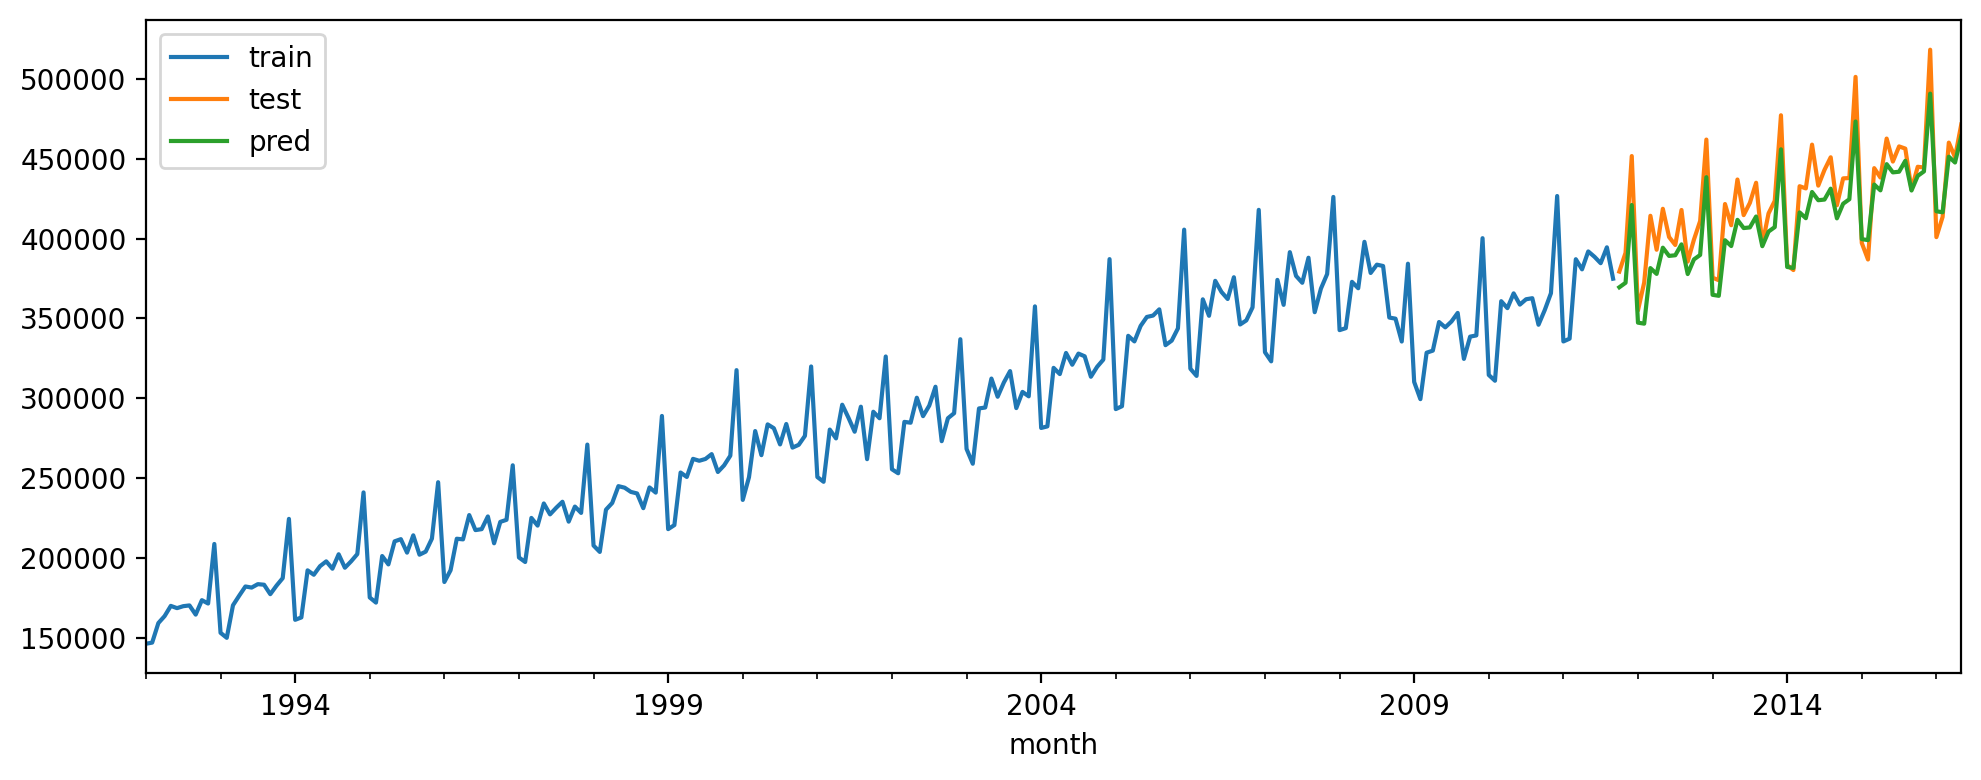

In [19]:
y_pred = model.predict(X_testf)

_, ax = plt.subplots(figsize=(10, 4))
_ = df_train.plot(ax=ax)
_ = df_test.plot(ax=ax)
_ = y_pred.plot(ax=ax)
_ = ax.legend(["train", "test", "pred"])
_ = plt.tight_layout()

print_metrics(y_testf, y_pred)

Not too bad for this rather peculiar approach.

## Side Note: Autocorrelation!
By the way, there's a different/better way to get an insight into seasonalities apart from this cumbersome stuff above!

For this, we'll again need to de-trend the data first. We can do this by subtracting the trend we got from the decomposition but let's try a different trend calculation here.

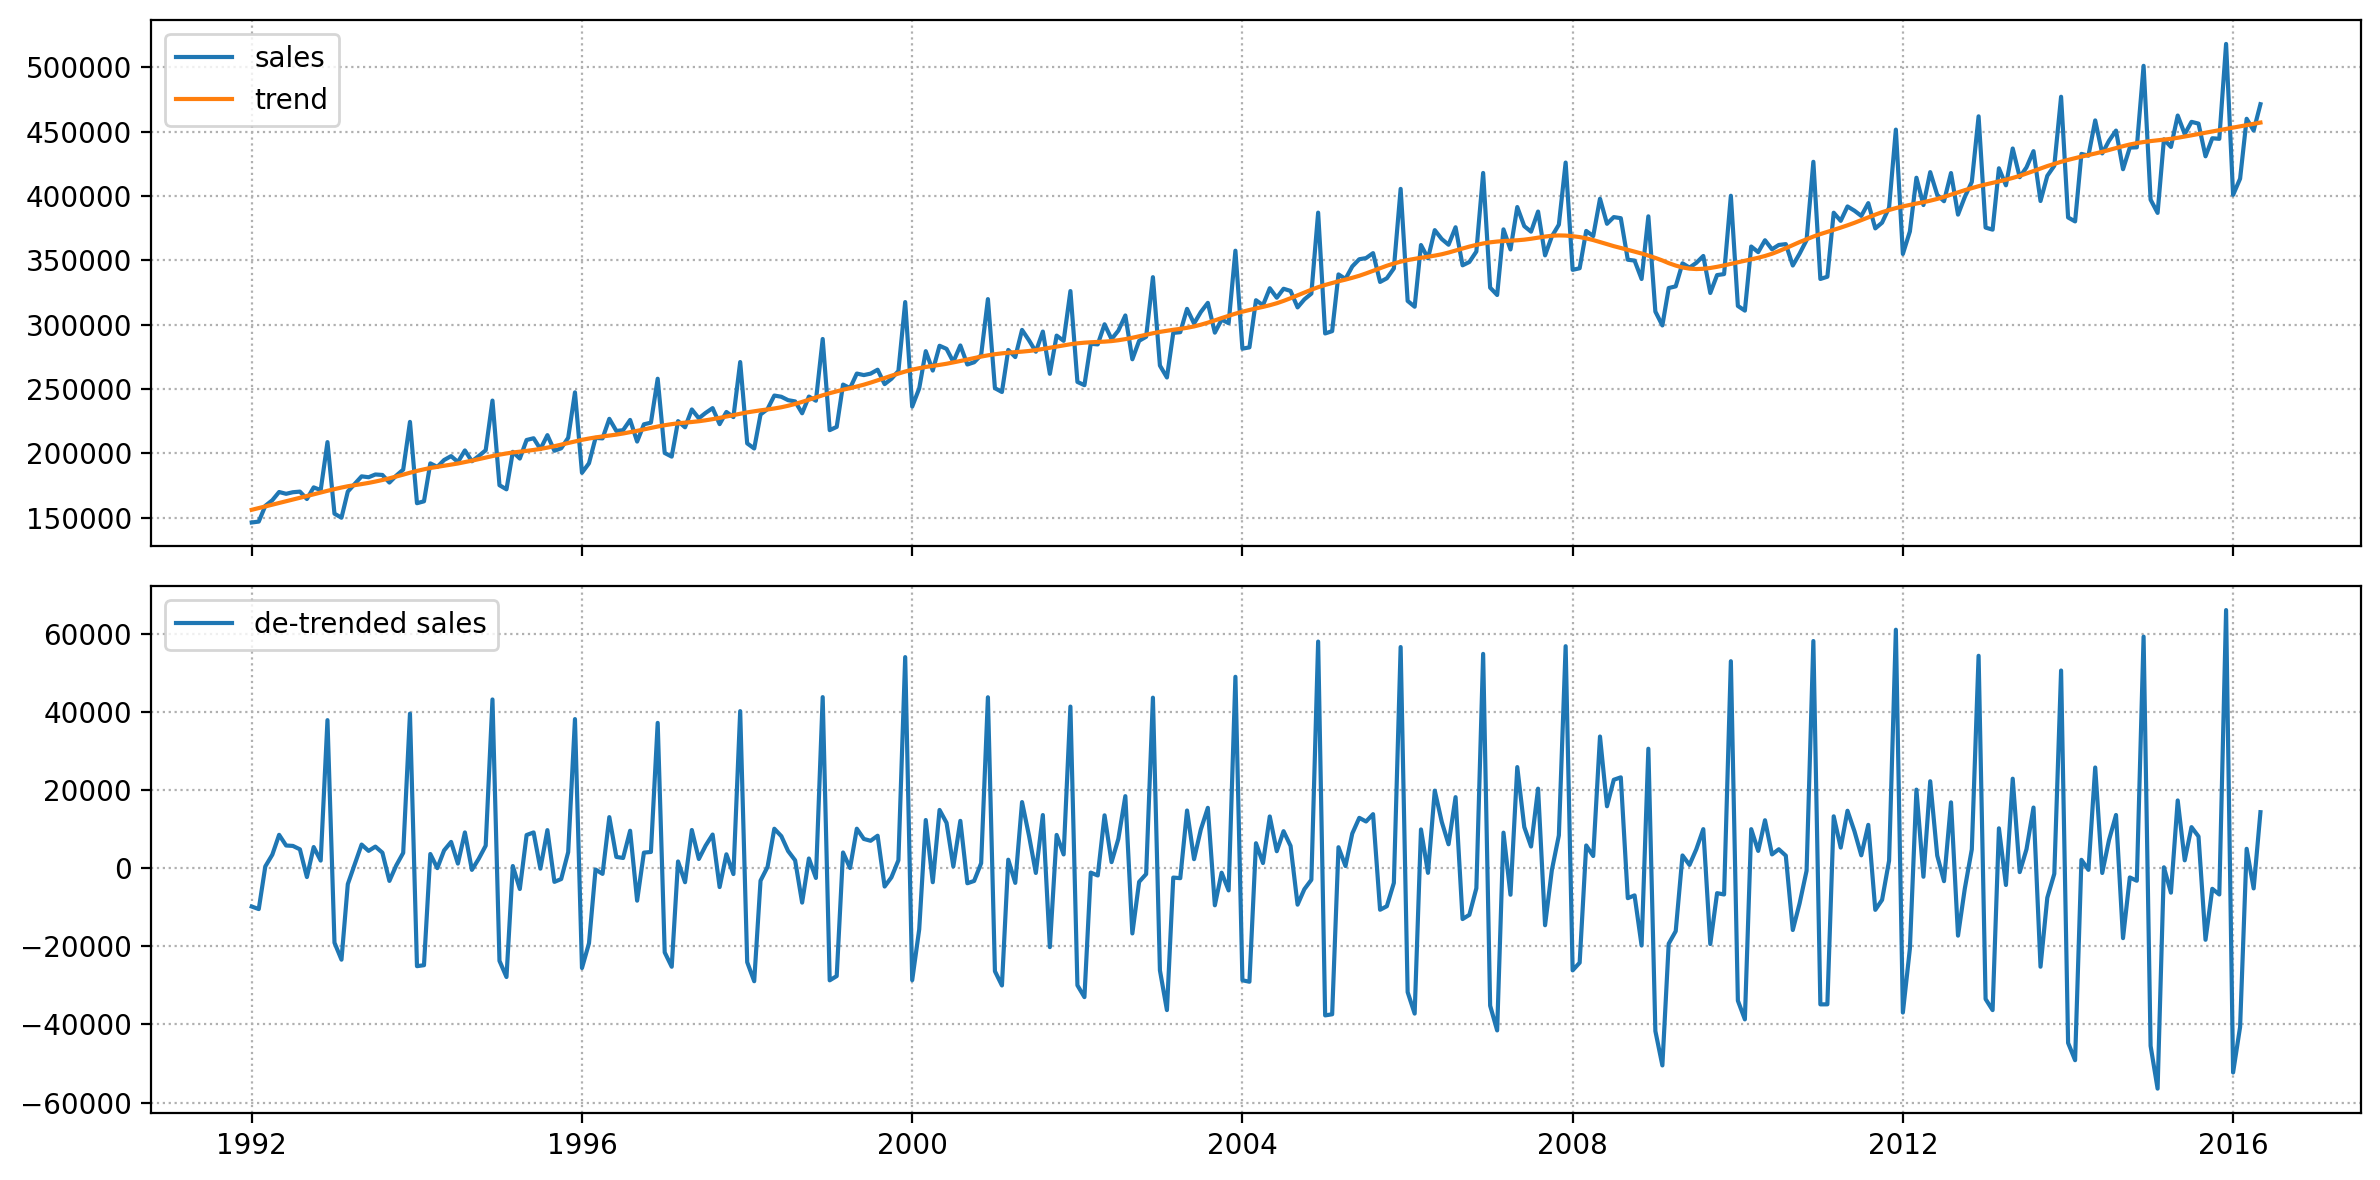

In [50]:
from statsmodels.nonparametric.smoothers_lowess import lowess

df["trend"] = lowess(endog=df["sales"], exog=np.arange(0, len(df)), frac=0.1)[:, 1]
df["detrended_sales"] = df["sales"] - df["trend"]

_, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
_ = axs[0].plot(df["sales"], label="sales")
_ = axs[0].plot(df["trend"], label="trend")
_ = axs[1].plot(df["detrended_sales"], label="de-trended sales")
for ax in axs:
    ax.grid(linestyle=":")
    ax.legend()
_ = plt.tight_layout()

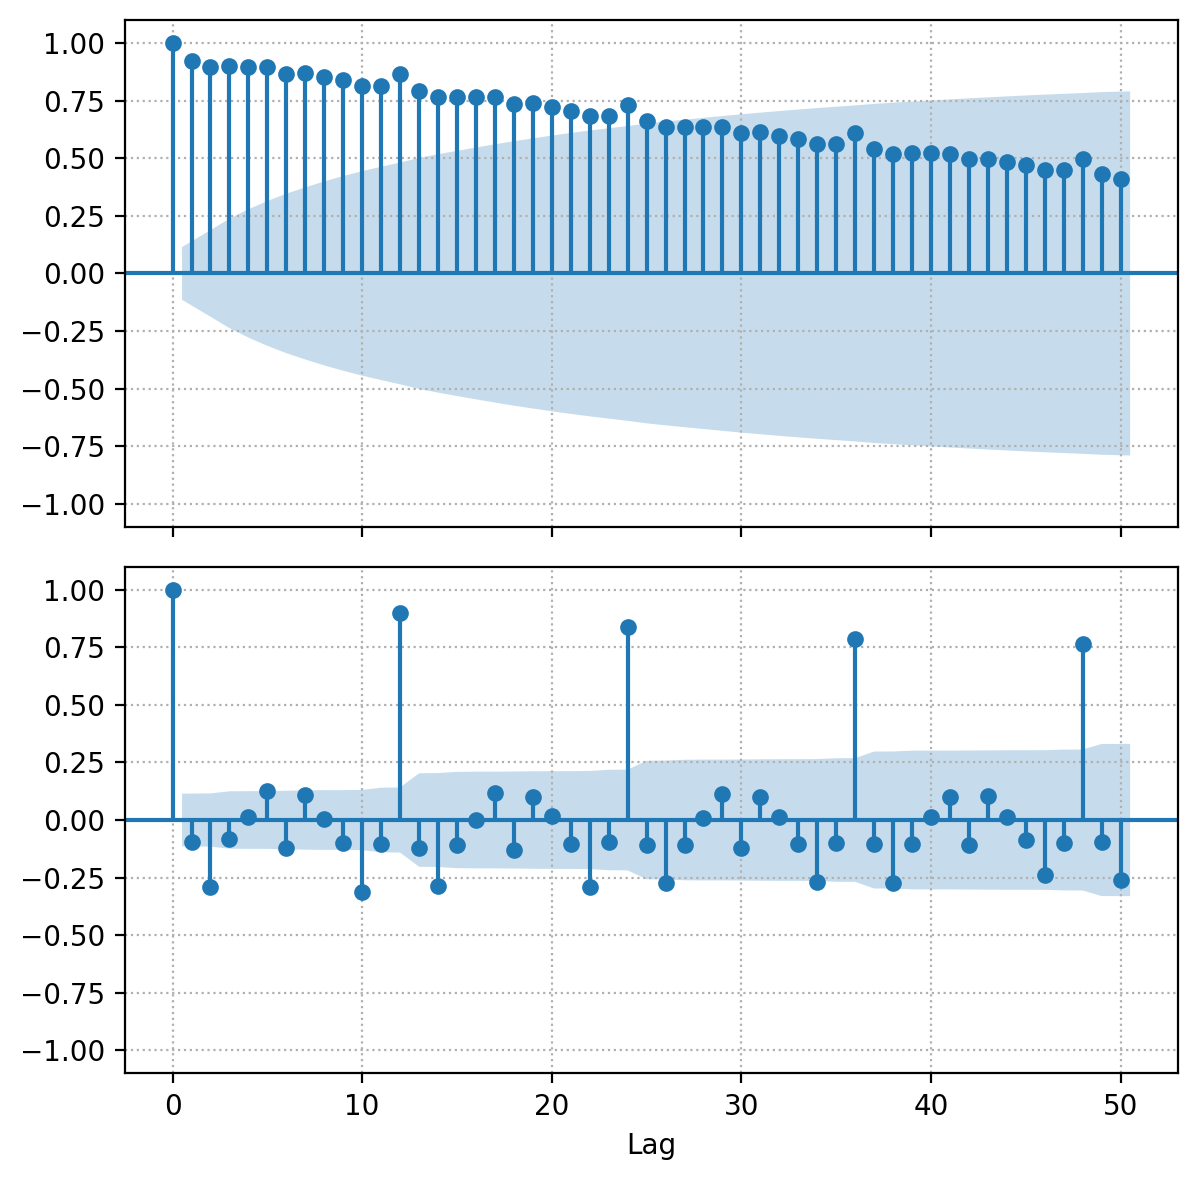

In [61]:
from statsmodels.graphics.tsaplots import plot_acf

_, axs = plt.subplots(2,1,figsize=(6, 6), sharex=True)
_ = plot_acf(x=df["sales"], lags=50, ax=axs[0])
_ = axs[0].set_ylim((-1.1,1.1))
_ = axs[0].set_title("")
_ = plot_acf(x=df["sales"]- df["trend"], lags=50, ax=axs[1])
_ = axs[1].set_ylim((-1.1,1.1))
_ = axs[1].set_xlabel("Lag")

for ax in axs:
    _ = ax.set_title("")
    _ = ax.grid(linestyle=":")
_ = plt.tight_layout()

And we finally have a very clear and significant seasonality pattern. Even some significant anticorrelations, apparently.

But back to the problem at hand. Let's find an even better way to predict these sales!



## The Cheat: Facebook Prophet!
What's that? You ask. &#x1F914; Let's find out with ChatGPT!

**Prompt:** 

Hi ChatGPT, can you write me a short markdown text explaining how Facebook prophet works? And please use some LaTeX expressions!

**Response:**

Certainly! Facebook Prophet is a time series forecasting model that decomposes the data into several components, including a trend component, a seasonal component, and a residual component. The additive composition of these components can be expressed as:

\begin{equation}
y(t) = g(t) + s(t) + h(t) + \epsilon_t
\end{equation}

where:

- $y(t)$ is the observed time series at time $t$
- $g(t)$ is the trend component, which models the non-periodic changes in the time series over time
- $s(t)$ is the seasonal component, which models the periodic changes in the time series over time
- $h(t)$ is the holiday component, which models the effects of holidays and other events that occur irregularly over time
- $\epsilon_t$ is the residual component, which represents the random fluctuations in the time series that are not explained by the other components.


Great! Thanks massive, uncanny language model that's on the verge of making my job obsolete! &#x1F9D0;
 
### A word of caution  for Mac useres. &#x1F34F;
- Prophet still is notoriously finnicky to set up on Apple M1 and M2 machines. 
- We didn't get it to run and didn't bother a lot. 
- So, look out for obscure errors when running the following code locally.

Moving on!

In [ ]:
# Prophet demands a certain naming of data frame columns:
df_prophet = df.reset_index().rename(columns={"month": "ds", "sales": "y"})
df_prophet.head()

,ds,y
0,1992-01-01,146376
1,1992-02-01,147079
2,1992-03-01,159336
3,1992-04-01,163669
4,1992-05-01,170068


In [ ]:
from prophet import Prophet

df_train = df_prophet.loc[df_prophet.ds < SPLIT_DATE].copy()
df_test = df_prophet.loc[df_prophet.ds >= SPLIT_DATE].copy()

m = Prophet()
_ = m.fit(df_prophet)

09:59:01 - cmdstanpy - INFO - Chain [1] start processing
09:59:01 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
in_sample = m.predict(df_train[["ds"]])
forecast = m.predict(df_test[["ds"]])
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2011-10-01,385404.135301,369189.160784,389161.288822,385404.135301,385404.135301,-5916.932233,-5916.932233,-5916.932233,-5916.932233,-5916.932233,-5916.932233,0.0,0.0,0.0,379487.203069
1,2011-11-01,386839.044012,374452.480138,394514.494184,386839.044012,386839.044012,-2587.382656,-2587.382656,-2587.382656,-2587.382656,-2587.382656,-2587.382656,0.0,0.0,0.0,384251.661356
2,2011-12-01,388227.665344,428804.547853,449449.689008,388227.665344,388227.665344,50918.360353,50918.360353,50918.360353,50918.360353,50918.360353,50918.360353,0.0,0.0,0.0,439146.025697
3,2012-01-01,389662.574054,344889.175712,365415.719615,389662.574054,389662.574054,-34256.099352,-34256.099352,-34256.099352,-34256.099352,-34256.099352,-34256.099352,0.0,0.0,0.0,355406.474702
4,2012-02-01,391097.482765,350177.296652,370607.542883,391097.482765,391097.482765,-30496.627171,-30496.627171,-30496.627171,-30496.627171,-30496.627171,-30496.627171,0.0,0.0,0.0,360600.855594


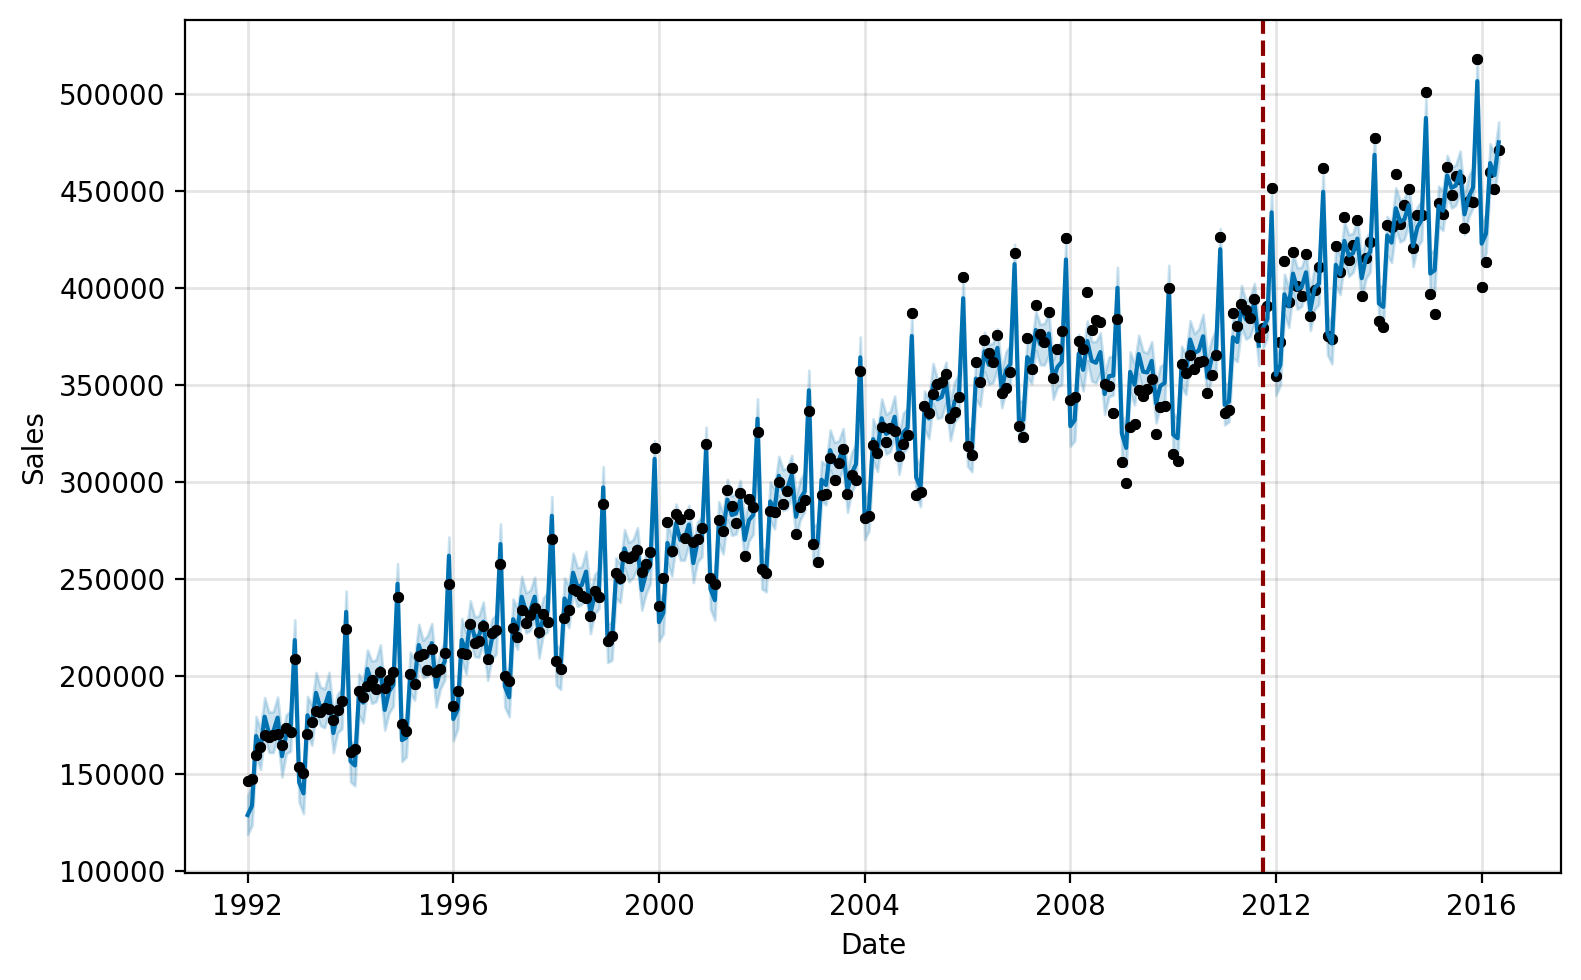

In [ ]:
_, ax = plt.subplots(figsize=(8, 5))
_ = m.plot(in_sample, ax=ax)
_ = m.plot(forecast, ax=ax)
_ = ax.axvline(pd.to_datetime(SPLIT_DATE), color="darkred", linestyle="--")
_ = ax.set_xlabel("Date")
_ = ax.set_ylabel("Sales")

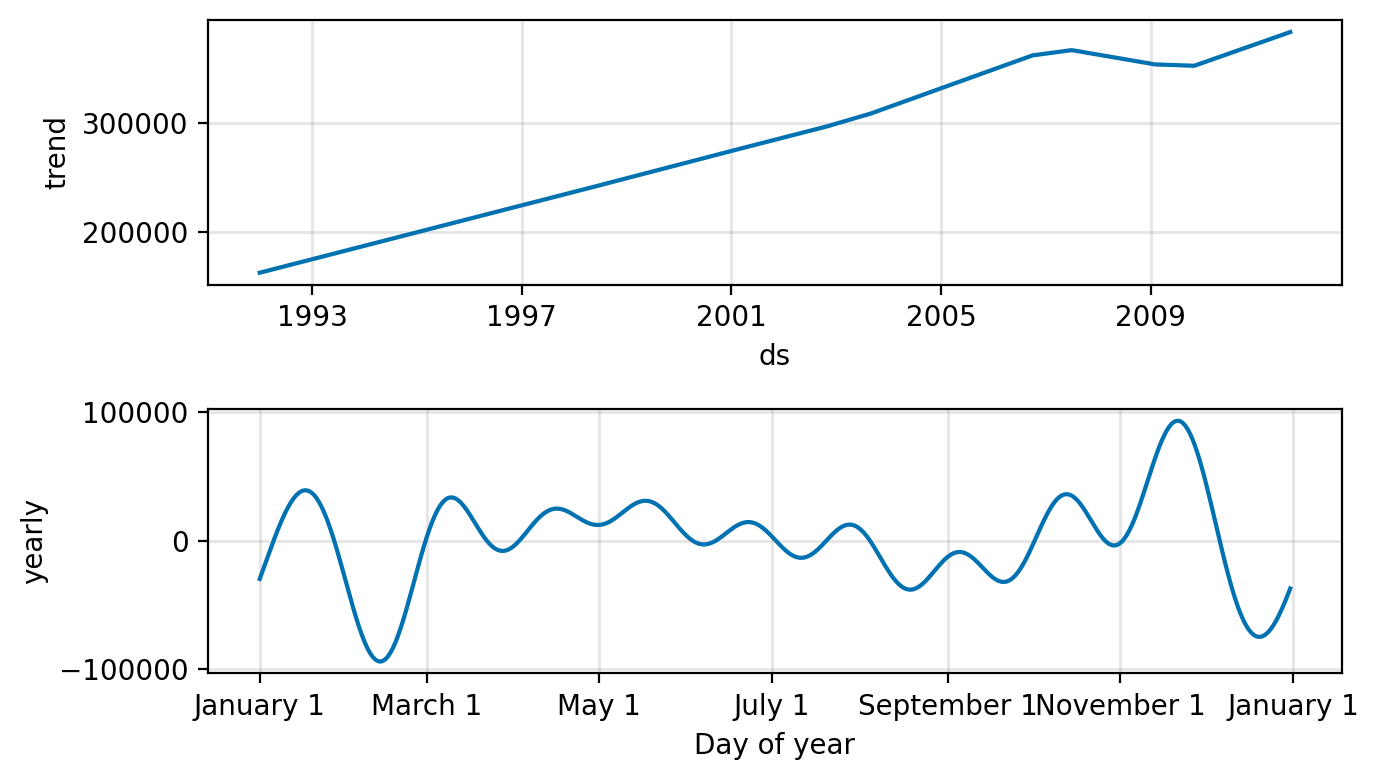

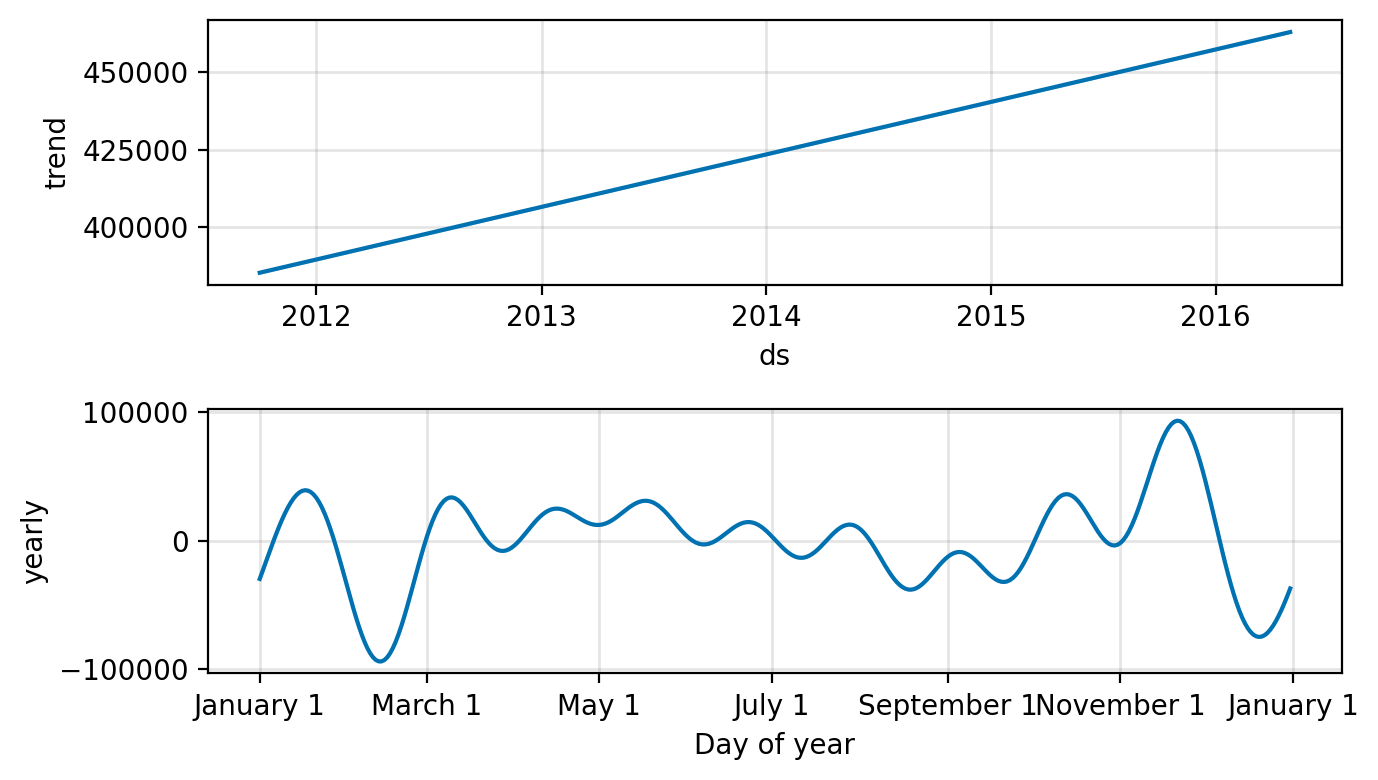

In [ ]:
# We can look at the resulting components of the model:
_ = m.plot_components(in_sample, figsize=(7,4))
_ = m.plot_components(forecast, figsize=(7,4))

In [ ]:
print_metrics(df_test["y"], forecast["yhat"])

RMSE:    8783.06
MAE:     6984.01
MAPE:       1.64%


## Why is this cheating a little bit? &#x1F92F;
- Well, if you take a look at the data source URL it turns out to be a toy example **from the Prophet package**! 
- Such toy examples necessarily perform really well and are a bit uncritical to potential weaknesses of the model.

## Why this is better than it looks? &#x1F632;
- So far, we have limited ourselves to single-step forecasts. Only forecast one hour, one day, one month or so into the future.
- Prophet does the whole thing: It produces a multi-horizon forecast without having seen the test data!! 

Note that also our super weird instructive estimator above did this, but it was a bit more cumbersome to set up.

Let's dive into multi-step ahead forecasts in the next notebook!